In [1]:
# used during development to releoad modules every time there is a change
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from risk_kit import Metrics, pre_processing_ind, get_ind30_nfirms, get_ind30_size, plot_ef2
pd.options.display.float_format = '{:.6f}'.format

In [2]:
metrics= Metrics()
ind_return = pre_processing_ind()
ind_nfirms = get_ind30_nfirms()
ind_size = get_ind30_size()

#### Total Market Index Return

In [3]:
# Total Market Cap: nr. of shares outstanding * price per share (not considering the float adjustment)
ind_mkt_cap = ind_nfirms * ind_size
tot_mktcap = ind_mkt_cap.sum(axis=1)
# weights of the industries over time
ind_capweight = ind_mkt_cap.div(tot_mktcap, axis=0) # division by rows
# cap-weighted market index
tmi_return = (ind_capweight * ind_return).sum(axis=1)

In [4]:
# risky assets
asset_to_invest = ["Steel", "Fin", "Beer"]
risky_r = ind_return["2000":][asset_to_invest]
risky_r.shape

(228, 3)

In [5]:
# safe asset (set of returns with the same shape of risky assets
safe_r= pd.DataFrame().reindex_like(risky_r) # gives a dataframe with the same shape
safe_r.shape

(228, 3)

In [6]:
# Starting Condition
safe_r[:] = 0.03/12 # 3% safe asset annual return
start = 1000
floor =  0.8
floor_value = start*floor
m=3

In [7]:
cppi_res = metrics.run_cppi(risky_r, safe_r= safe_r,\
                            start=start, floor=floor, m=m)

In [8]:
# Account History (using CPPI technique)
account_history = cppi_res["Wealth"]
cppi_res["Wealth"].head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


In [9]:
# Risky Wealth
# (what would I have got If I had put all of my money in the risky assets)
risky_wealth = cppi_res["Risky Wealth"]
cppi_res["Risky Wealth"].head()

,Steel,Fin,Beer
2000-01,972.300000,955.800000,977.200000
2000-02,1038.805320,874.652580,863.453920
2000-03,1075.059626,1020.632096,864.576410
2000-04,1066.029125,977.255232,896.392822
2000-05,1013.580492,1026.704346,1002.794650


In [10]:
# Cushion History
cushion_history = cppi_res["Risky Budget"]
cppi_res["Risky Budget"].head()

,Steel,Fin,Beer
2000-01,0.200000,0.200000,0.200000
2000-02,0.187306,0.179049,0.189726
2000-03,0.218210,0.140864,0.133234
2000-04,0.236317,0.198547,0.134982
2000-05,0.232304,0.178584,0.148930


In [11]:
# Risky Allocation
risky_w_history = cppi_res["Risky Allocation"]
cppi_res["Risky Allocation"].head()

,Steel,Fin,Beer
2000-01,0.600000,0.600000,0.600000
2000-02,0.561917,0.537148,0.569177
2000-03,0.654630,0.422591,0.399702
2000-04,0.708951,0.595642,0.404945
2000-05,0.696912,0.535751,0.446791


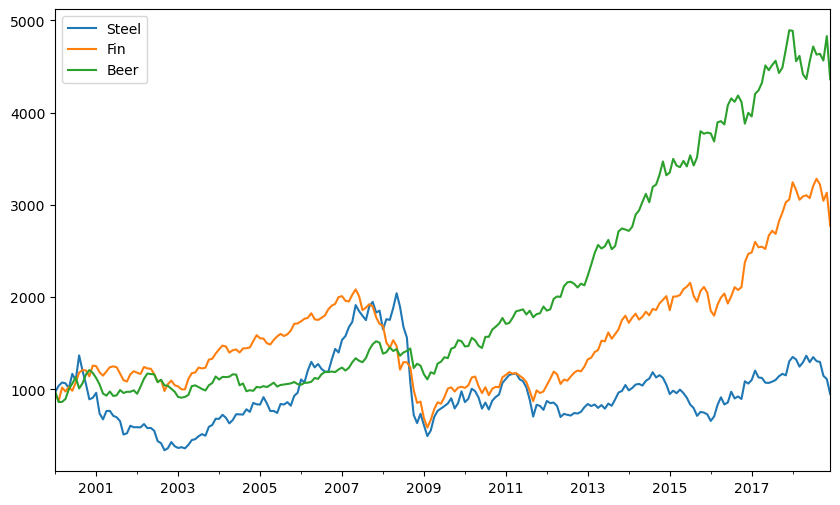

In [12]:
# Plot the wealth index: what would I have got If I had put all of my money in the risky assets
risky_wealth.plot();

#### Analysis of CCPI effect on single assets

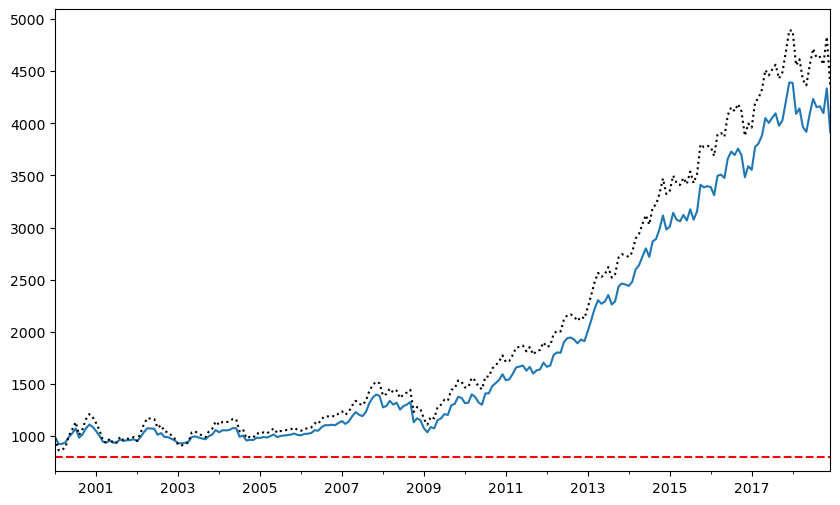

In [13]:
ax = account_history["Beer"].plot() # blue line
risky_wealth["Beer"].plot(ax=ax, style="k:") # black color
ax.axhline(y=floor_value, color="r", linestyle ="--"); # floor value

COMMENT: The blue line is much less volatile since it is a mix of the risky assets and the safe assets. The floor when the returns are very high (after 2009) becomes irrelevant (low probability of falling to the floor level) -> we will implement the CPPI with Max DD

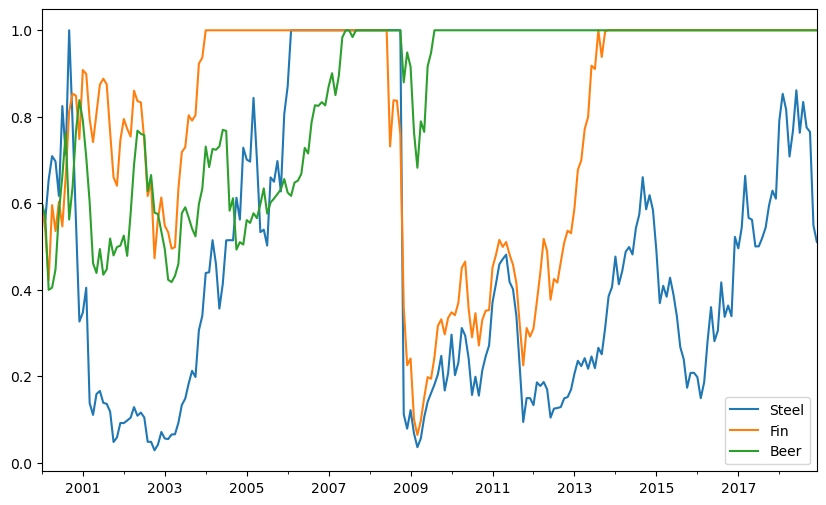

In [14]:
risky_w_history.plot();

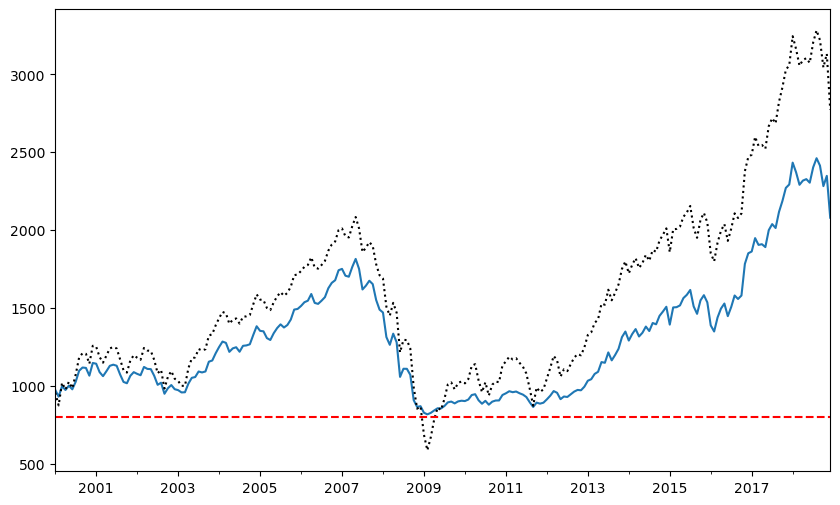

In [15]:
ax = account_history["Fin"].plot() # blue line
risky_wealth["Fin"].plot(ax=ax, style="k:") # black color
ax.axhline(y=floor_value, color="r", linestyle ="--"); # floor value

COMMENT: For Finance CPPI (blue line) was much more important since if we had invested only in this risky asset (Finance) we would have gone below our max tolerance (80% of the starting capital). Of course with CPPI by the end of 2018 we wouldn't have enjoyed the returns given by investing only in finance (black dashed line)

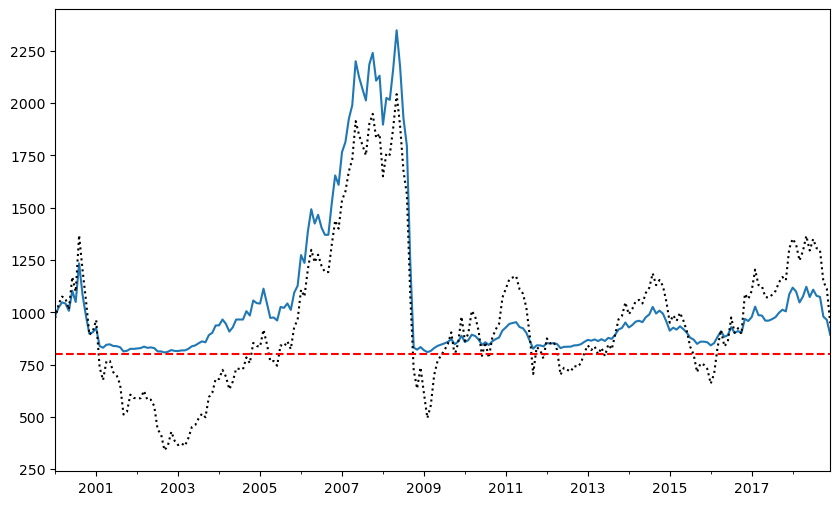

In [16]:
ax = account_history["Steel"].plot() # blue line
risky_wealth["Steel"].plot(ax=ax, style="k:") # black color
ax.axhline(y=floor_value, color="r", linestyle ="--") # floor value

COMMENT: For Steel the situation was even worse than for Finance.
In the case CPPI (blue line) saved us from multiple floor breaches.

In [17]:
#risky_r.agg(metrics.summary_stats)
obj = metrics.summary_stats(risky_r)
obj

,Ann. Return,Ann. Volatility,Skewness,Kurtosis,Corn-Fisher VaR (5%),Hist. CVar (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [21]:
# compute summary stats over CPPI portfolio
metrics.summary_stats(cppi_res["Wealth"].pct_change().dropna())

,Ann. Return,Ann. Volatility,Skewness,Kurtosis,Corn-Fisher VaR (5%),Hist. CVar (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


COMMENT: with the use of CPPI downside risk was reduced compared to the strategy without CPPI

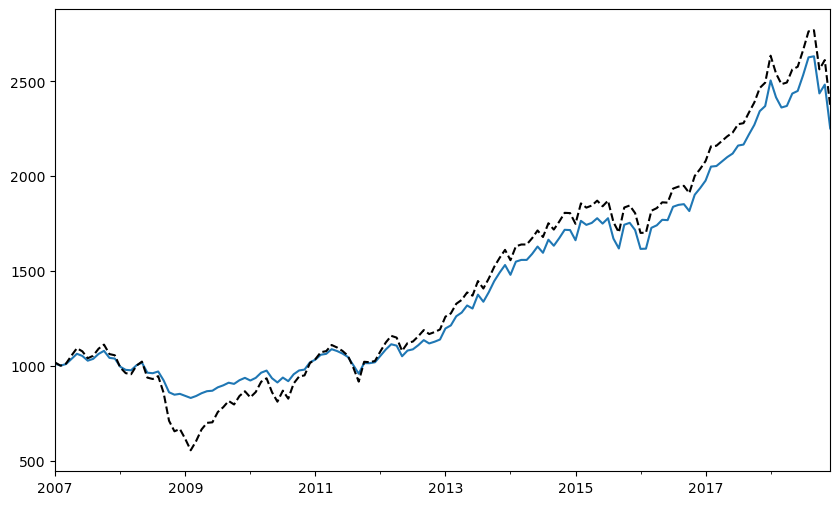

In [24]:
# let's run CPPI on the market index just before the 2008 market crash
mkt_idx_res = metrics.run_cppi(tmi_return["2007":])
ax = mkt_idx_res["Wealth"].plot(legend=False);
# plot on the same graph as the previous one
mkt_idx_res["Risky Wealth"].plot(ax=ax, style = "k--", legend=False);

COMMENT: during the 2008 crash CPPI helped a lot the capital preservation

In [30]:
obj2 = metrics.summary_stats(mkt_idx_res["Risky Wealth"].pct_change().dropna())
obj2

,Ann. Return,Ann. Volatility,Skewness,Kurtosis,Corn-Fisher VaR (5%),Hist. CVar (5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.071592,0.096315,0.280618,-0.499943


In [26]:
obj3 = metrics.summary_stats(mkt_idx_res["Wealth"].pct_change().dropna())
obj3

,Ann. Return,Ann. Volatility,Skewness,Kurtosis,Corn-Fisher VaR (5%),Hist. CVar (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.045678,0.062953,0.382052,-0.229683


COMMENT: If I had invested at the start of 2007 in the total mkt index with the CPPI technique my DD would have been at almost 23% compared to 50% (with no CPPI)

### Improving CPPI algo imposing a Drawdown constraint

In [32]:
asset_to_invest = ["Steel", "Fin", "Beer"]
btr =  metrics.run_cppi(ind_return["2007":][asset_to_invest], drawdown_constraint=0.25)

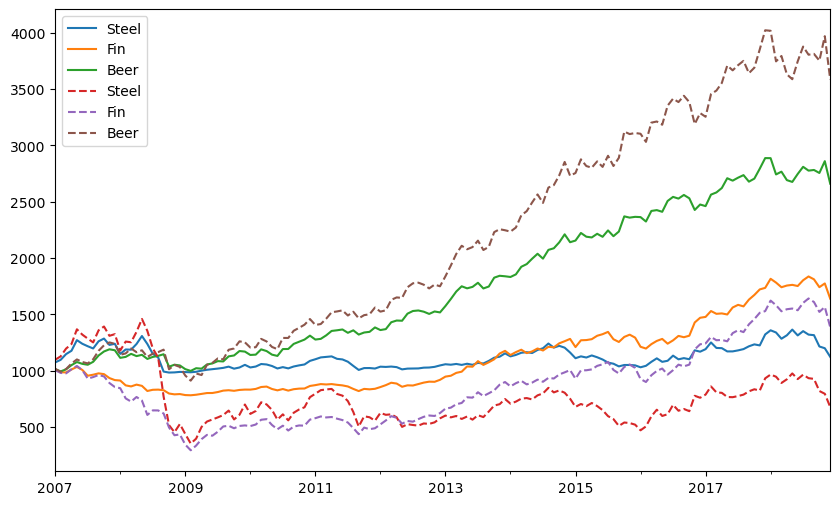

In [34]:
ax= btr["Wealth"].plot();
btr["Risky Wealth"].plot(ax=ax, style="--");

In [35]:
# no CPPI
metrics.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Ann. Return,Ann. Volatility,Skewness,Kurtosis,Corn-Fisher VaR (5%),Hist. CVar (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [36]:
# CPPI with DD constraint
metrics.summary_stats(btr["Wealth"].pct_change().dropna())

,Ann. Return,Ann. Volatility,Skewness,Kurtosis,Corn-Fisher VaR (5%),Hist. CVar (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.051189,0.613413,-0.161186


COMMENT: imposing a Max DD of 25% is respected only in the last case. In the first case CPPI is not applied at all.
CPPI is far more important than people give it credit for. It'a the basis for a lot of downside protection. Actually, plain CPPI is not implemented the way we did it since there are always some sophisticated tweaks alongside it. The reason we didn't have a violation of the DD constraint is because we are rebalancing our portfolio every single month. In reality you wouldn't want to do that due to higher trading costs. Generally we put some boundaries around our trading costs before executing a portfolio rebalance.

In [18]:
# Detour on for loop
def compound1(r):
    return (1+r).prod() - 1

# this is implemented with a for loop
def compound2(r):
    return np.expm1(np.log1p(r).sum())

In [19]:
%timeit compound1(risky_r)

349 µs ± 3.69 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [20]:
%timeit compound2(risky_r)

348 µs ± 6.34 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
